<a href="https://colab.research.google.com/github/J-oyin/Dr.-Jimoh-Analysis/blob/main/Weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, friedmanchisquare
import itertools


In [17]:
data = pd.read_excel("Dr. J_Weight.xlsx")

In [18]:
data.head()

,S/N,Group,Weight,conditions,Subject
0,1,Healthy,175,baseline,RC1
1,2,Healthy,195,baseline,RC2
2,3,Healthy,171,baseline,RC3
3,4,Healthy,211,baseline,RC4
4,5,Healthy,184,baseline,RC5


In [19]:
from scipy.stats import levene

grouped = [data[data['Group']==grp]['Weight'].values for grp in
           ['Healthy', 'Resilient', 'S/DW', 'S/RG108', 'S/Esc',
            'S/LASA', 'S/LASA+ESC', 'S/HASA', 'S/HASA+ESC']]

stat, p = levene(*grouped)
print(f"Levene Test: stat={stat:.3f}, p={p:.3f}")

if p > 0.05:
    print("Variances are homogeneous across groups")
else:
    print("Variances are NOT homogeneous across groups")


Levene Test: stat=nan, p=nan
Variances are NOT homogeneous across groups


/tmp/ipython-input-3744876182.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = levene(*grouped)


In [20]:
df = data

In [21]:
pivot = df.pivot(index='Subject', columns='conditions', values='Weight').dropna()

stat, p = friedmanchisquare(
    pivot['baseline'],
    pivot['post.indt'],
    pivot['post.tret']
)

print("Friedman χ² =", stat, "p =", p)


Friedman χ² = 22.108108108108095 p = 1.58228722483571e-05


In [22]:
import pandas as pd
from scipy.stats import friedmanchisquare

# Required condition order
conditions_order = ['baseline', 'post.indt', 'post.tret']

friedman_results = []

for grp, data in df.groupby('Group'):

    # Pivot so each subject has columns = conditions
    pivot = data.pivot(index='Subject', columns='conditions', values='Weight')

    # Keep only subjects with all 3 conditions
    pivot = pivot[conditions_order].dropna()

    # Skip if not enough subjects
    if pivot.shape[0] < 2:
        print(f"⚠️ Not enough subjects for Friedman in {grp}. Skipping.")
        continue

    # Run Friedman test
    stat, p = friedmanchisquare(
        pivot['baseline'],
        pivot['post.indt'],
        pivot['post.tret']
    )

    friedman_results.append({'Group': grp, 'Chi-square': stat, 'p-value': p})

friedman_results = pd.DataFrame(friedman_results)
print("\n=== FRIEDMAN RESULTS ===")
print(friedman_results)




=== FRIEDMAN RESULTS ===
       Group  Chi-square   p-value
0    Healthy    7.444444  0.024180
1  Resilient    8.315789  0.015640
2       S/DW    5.777778  0.055638
3      S/Esc    3.894737  0.142649
4     S/HASA    8.444444  0.014666
5     S/LASA    7.684211  0.021448


In [23]:

# ------- choose outcome variable -------
dv = 'Weight'   # change this to any measure you like

# ------- function to build the table -------
def make_desc_table(data, group_cols, dv):
    g = data.groupby(group_cols)[dv]

    desc = g.agg(
        N='count',
        Mean='mean',
        SD='std',
        SEM=lambda x: x.std(ddof=1) / np.sqrt(x.count()),
        Median='median',
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75),
        Min='min',
        Max='max'
    ).reset_index()

    # IQR
    desc['IQR'] = desc['Q3'] - desc['Q1']

    # round for manuscript
    num_cols = ['Mean', 'SD', 'SEM', 'Median', 'Q1', 'Q3', 'IQR', 'Min', 'Max']
    desc[num_cols] = desc[num_cols].round(2)

    # formatted columns often reported in papers
    desc['Mean ± SD'] = desc['Mean'].astype(str) + ' ± ' + desc['SD'].astype(str)
    desc['Median (IQR)'] = (
        desc['Median'].astype(str) + ' (' +
        desc['Q1'].astype(str) + '–' +
        desc['Q3'].astype(str) + ')'
    )

    # column order
    cols_order = (
        group_cols +
        ['N', 'Mean', 'SD', 'SEM', 'Mean ± SD',
         'Median', 'Q1', 'Q3', 'IQR', 'Median (IQR)', 'Min', 'Max']
    )
    desc = desc[cols_order]

    return desc

# ------- build table: per Group × Condition -------
group_cols = ['Group', 'conditions']   # change if you want only Group, etc.
desc_table = make_desc_table(df, group_cols, dv)

print(desc_table)

# ------- export to Excel -------
output_file = f"Descriptive_stats_{dv}.xlsx"
desc_table.to_excel(output_file, index=False)
print("Saved to:", output_file)


        Group conditions  N   Mean     SD    SEM      Mean ± SD  Median  \
0     Healthy   baseline  5  187.2  16.19   7.24  187.2 ± 16.19   184.0   
1     Healthy  post.indt  5  194.2  16.08   7.19  194.2 ± 16.08   195.0   
2     Healthy  post.tret  5  200.4  17.31   7.74  200.4 ± 17.31   195.0   
3   Resilient   baseline  5  195.6  13.65   6.10  195.6 ± 13.65   194.0   
4   Resilient  post.indt  5  204.6  17.64   7.89  204.6 ± 17.64   209.0   
5   Resilient  post.tret  5  205.6  17.30   7.74   205.6 ± 17.3   208.0   
6        S/DW   baseline  5  197.2   6.22   2.78   197.2 ± 6.22   198.0   
7        S/DW  post.indt  5  203.2   9.26   4.14   203.2 ± 9.26   202.0   
8        S/DW  post.tret  5  195.6   9.81   4.39   195.6 ± 9.81   192.0   
9       S/Esc   baseline  5  193.8  12.97   5.80  193.8 ± 12.97   189.0   
10      S/Esc  post.indt  5  204.4  18.80   8.41   204.4 ± 18.8   199.0   
11      S/Esc  post.tret  5  191.2  26.64  11.91  191.2 ± 26.64   193.0   
12     S/HASA   baseline 

/tmp/ipython-input-3220736695.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


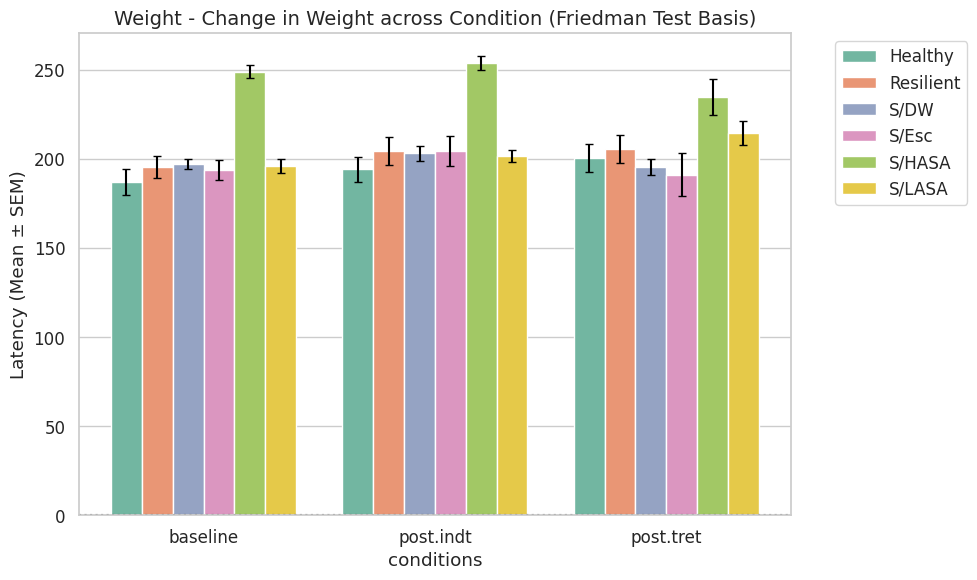

In [24]:
summary = (
    df.groupby(['Group', 'conditions'])['Weight']
      .agg(['mean', 'sem'])
      .reset_index()
)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.1)

# Create the barplot (mean values)
ax = sns.barplot(
    data=summary,
    x='conditions',
    y='mean',
    hue='Group',
    ci=None,  # we are providing our own SEM
    capsize=0.1,
    palette='Set2'
)

for i, row in summary.iterrows():
    group_index = list(summary['Group'].unique()).index(row['Group'])
    cond_index = list(summary['conditions'].unique()).index(row['conditions'])
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width()/2
    y = row['mean']
    plt.errorbar(x, y, yerr=row['sem'], fmt='none', ecolor='black', capsize=3)

plt.title("Weight - Change in Weight across Condition (Friedman Test Basis)", fontsize=14)
plt.ylabel("Latency (Mean ± SEM)")
plt.xlabel("conditions")
plt.axhline(color='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


In [25]:
from scipy.stats import wilcoxon
import itertools

# Filter only the three groups
groups_of_interest = [ 'S/LASA', 'S/LASA+ESC']
df_sub = df[df['Group'].isin(groups_of_interest)]


In [26]:
data_group = df[df['Group'] == 'Healthy']
data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Weight')
print("Pivot columns:", data_pivot.columns)


Pivot columns: Index(['baseline', 'post.indt', 'post.tret'], dtype='object', name='conditions')


In [27]:
import itertools
from scipy.stats import wilcoxon

condition_pairs = list(itertools.combinations(df['conditions'].unique(), 2))
results = []

for g in ['S/LASA','S/HASA','Healthy','Resilient']:
    data_group = df[df['Group'] == g]
    data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Weight')

    for cond1, cond2 in condition_pairs:
        if cond1 in data_pivot.columns and cond2 in data_pivot.columns:
            valid = data_pivot[[cond1, cond2]].dropna()
            stat, p = wilcoxon(valid[cond1], valid[cond2])
            results.append({'Group': g, 'Comparison': f'{cond1} vs {cond2}', 'Statistic': stat, 'p-value': p})
        else:
            print(f"⚠️ Skipped {g}: missing {cond1} or {cond2}")

import pandas as pd
posthoc_df = pd.DataFrame(results)
print(posthoc_df)


        Group              Comparison  Statistic  p-value
0      S/LASA   baseline vs post.indt        0.0   0.1250
1      S/LASA   baseline vs post.tret        0.0   0.0625
2      S/LASA  post.indt vs post.tret        1.0   0.1250
3      S/HASA   baseline vs post.indt        0.0   0.0625
4      S/HASA   baseline vs post.tret        1.0   0.5000
5      S/HASA  post.indt vs post.tret        0.0   0.0625
6     Healthy   baseline vs post.indt        0.0   0.1250
7     Healthy   baseline vs post.tret        0.0   0.0625
8     Healthy  post.indt vs post.tret        1.0   0.2500
9   Resilient   baseline vs post.indt        0.0   0.0625
10  Resilient   baseline vs post.tret        0.0   0.0625
11  Resilient  post.indt vs post.tret        1.5   0.3750


In [28]:
!pip install statannotations


/tmp/ipython-input-666532150.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-666532150.py:10: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  ax = sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S/LASA_baseline vs. S/LASA_post.tret: Custom statistical test, P_val:6.250e-02
S/HASA_baseline vs. S/HASA_post.tret: Custom statistical test, P_val:5.000e-01
Resilient_baseline vs. Resilient_post.tret: Custom statistical test, P_val:6.250e-02
Healthy_baseline vs. Healthy_post.tret: Custom statistical test, P_val:6.250e-02


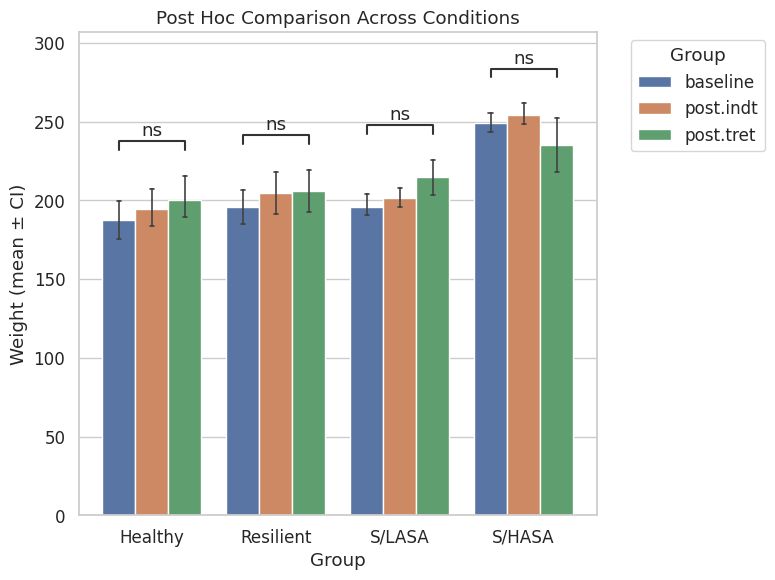

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Filter only the groups used in post hoc analysis
plot_df = df[df['Group'].isin(['S/LASA','S/HASA','Healthy','Resilient'])]

# Set up figure
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_df,
    x='Group', y='Weight', hue='conditions',
    ci=95, capsize=0.1, errwidth=1.2
)

# Move legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Group')

def get_star(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"

# Define your post hoc pairs
pairs = [
    (("S/LASA", "baseline"), ("S/LASA", "post.tret")),
    (("S/HASA", "baseline"), ("S/HASA", "post.tret")),
    (("Healthy", "baseline"), ("Healthy", "post.tret")),
    (("Resilient", "baseline"), ("Resilient", "post.tret"))
]

# Extracting p-values from posthoc_df for the defined pairs
p_values = []
for (group_cond1, cond1), (group_cond2, cond2) in pairs:
    group = group_cond1 # Assuming group_cond1 and group_cond2 are the same for a pair
    comparison_string = f'{cond1} vs {cond2}'
    p_value_row = posthoc_df[(posthoc_df['Group'] == group) & (posthoc_df['Comparison'] == comparison_string)]
    if not p_value_row.empty:
        p_values.append(p_value_row['p-value'].iloc[0])
    else:
        print(f"Warning: No p-value found for Group: {group}, Comparison: {comparison_string}")
        # You might want to handle this case differently, e.g., append a default value or skip the annotation for this pair

# Add significance stars
# Ensure the `y` variable here matches the one used in `sns.barplot`
annot = Annotator(ax, pairs, data=plot_df, x='Group', y='Weight', hue='conditions')
annot.configure(test=None, text_format='star', loc='inside', verbose=2)
annot.set_pvalues(p_values)
annot.annotate()

# Beautify the plot
plt.title('Post Hoc Comparison Across Conditions')
plt.xlabel('Group') # Changed x-label to 'Group' as per plot_df and barplot setup
plt.ylabel('Weight (mean \u00b1 CI)') # Changed y-label to 'Weight' as per plot_df and barplot setup
plt.tight_layout()
plt.show()

In [30]:
!pip install scikit-posthocs statannotations pingouin
